# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 4 files that contain the dataset:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

# PyTorch Dataset

Here you will implement a simple pytorch dataset that loads the images and labels as describe in the PDF.

In [1]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class HW3Dataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.path = path
        ## indicate the path for different dataset
        # imgs & mask data is h5 format
        # labels & bboxes data is npy format
        imgs_path, masks_path, labels_path, bboxes_path = self.path
        # load the data coarse data
        self.imgs_data = h5py.File(imgs_path, 'r')['data'][:]
        self.labels_data = np.load(labels_path,allow_pickle=True)
        self.masks_data = np.array(h5py.File(masks_path, 'r')['data'][:],dtype=np.int8)
        self.bboxes_data = np.load(bboxes_path,allow_pickle=True)
        # assign the multiple mask to each img
        index_assign = 0
        self.mask_list = []
        for i,element in enumerate(self.labels_data):
            # how many items in this image
            item_number = len(element)
            mask_pict = self.masks_data[index_assign:index_assign+item_number,]
            self.mask_list.append(mask_pict)
            # next iteration index
            index_assign += item_number
        self.mask_list = np.array(self.mask_list)
    def __getitem__(self, index):
#         batch = {'index': index}
        img = torch.tensor((self.imgs_data[index]/255-0.5)/0.5, dtype = torch.double)
        label = torch.tensor(self.labels_data[index], dtype = torch.double)
        mask = torch.tensor(self.mask_list[index])
        bbox = torch.tensor(self.bboxes_data[index], dtype = torch.double)
        return img, label, mask, bbox
    def __len__(self):
        return len(self.imgs_data)

In [2]:
# file path and make a list
imgs_path = './hw3_mycocodata_img_comp_zlib.h5'
masks_path = './hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "./hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path,masks_path,labels_path,bboxes_path]
# load the data into data.Dataset
dataset = HW3Dataset(paths)

# push the dataset into the dataloader

In [3]:
# set 80% of the dataset as the training data 
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_dataset = torch.utils.data.Subset(dataset, range(train_size))
# test_dataset = torch.utils.data.Subset(dataset, range(train_size,full_size))
# push the randomized training data into the dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)


# Dataset test

We suggest coming up with a test for your dataset. Testing and confirming that all of this works as expected here will save you headache later.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
tensor([[170.9187, 175.4688, 208.9187, 260.7188]], dtype=torch.float64)
i-th mask 0


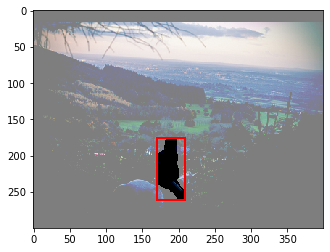

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
tensor([[106.7125,  21.2062, 184.3750, 219.8062]], dtype=torch.float64)
i-th mask 0


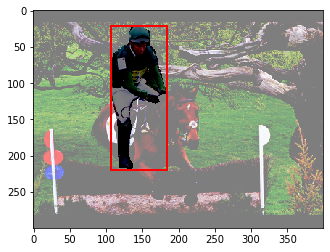

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
tensor([[130.5250, 113.6687, 247.7937, 243.2625],
        [129.1625,  59.8250, 226.0312, 198.7875]], dtype=torch.float64)
i-th mask 0
i-th mask 1


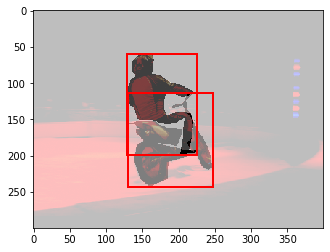

In [4]:
# test the dataset
for i,data in enumerate(train_loader,0):
    img, label, mask, bbox = data
    fig,ax = plt.subplots(1)
    ax.imshow(np.array(img.squeeze(0)).transpose(1,2,0))
    print(bbox.shape[1])
    print(bbox.squeeze(0))
    for i in range(bbox.squeeze(0).shape[0]):
        x1,y1,x2,y2 = bbox.squeeze(0)[i]
        rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
        ax.add_patch(rect)
#     plt.show()
    for i in range(mask.squeeze(0).shape[0]):
#         plt.imshow(mask.squeeze(0)[i]) 
        print("i-th mask",i)
        plt.imshow(mask.squeeze(0)[i], 'Greys', interpolation='none', alpha=0.5)
    plt.show()
    if i == 1:
        break

# Model Definition

In [5]:
class RPN(torch.nn.Module):
    def __init__(self):
        super(RPN,self).__init__()
        ## First construct the feature map CNN
        # max-pooling layer
        self.max_pool1 = nn.MaxPool2d(2,stride=2,padding=0)
        # conv layer and batch norm layer
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv2_bn = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv4_bn = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, 5, padding=2)
        self.conv5_bn = nn.BatchNorm2d(256)
        
        ## Second construct the feature map CNN
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv6_bn = nn.BatchNorm2d(256)
        # cls branch
        self.conv_cls = nn.Conv2d(256,1,1)
        # reg branch
        self.conv_reg = nn.Conv2d(256,4,1)
    def forward(self, X):
        ## input image X into the feature map CNN
        X = F.relu(self.conv1_bn(self.conv1(X)))
        X = self.max_pool1(X)
        X = F.relu(self.conv2_bn(self.conv2(X)))
        X = self.max_pool1(X)
        X = F.relu(self.conv3_bn(self.conv3(X)))
        X = self.max_pool1(X)
        X = F.relu(self.conv4_bn(self.conv4(X)))
        X = self.max_pool1(X)
        X = F.relu(self.conv5_bn(self.conv5(X)))
#         print(X.size())
        ## Afterwards, push the feature map into RPN CNN and divide into two branches
        X = F.relu(self.conv6_bn(self.conv6(X)))
        # for the classcification net
        X_cls = F.sigmoid(self.conv_cls(X))
        # for the regression net
        X_reg = self.conv_reg(X)
        
        return X_cls, X_reg

# Get the histgram for the scale and ratio


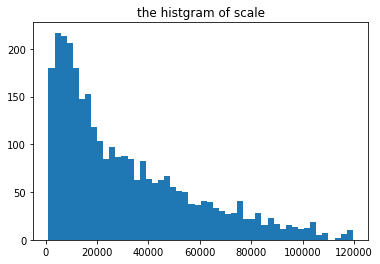

the mode of the box scale in the training data: 3495.0


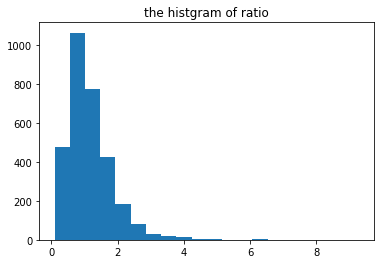

the mode of the box ratio in the training data: 1.0


In [44]:
## this part will encode the ground truth for later training use
# static about ground truth bounding boxes statistics
def statsBbox(dataset):
    # creat a list to record all the bbox
    bboxes_list = []
    # loop through the dataset to record the bbox w,h in the training data
    for i in range(len(dataset)):
        # get the bbox items for the i-th data
        _,_,_,bbox = dataset[i]
        # loop through the boxes in each of the image if there are multiple boxes
        for single_box in bbox:
            # record the w & h
            w = single_box[2].item() - single_box[0].item()
            h = single_box[3].item() - single_box[1].item()
            # add it to the list
            bboxes_list.append([w,h])
    # change the format to the array
    bboxes_array = np.array(bboxes_list)
    # extract the w&h information
    w_array = bboxes_array[:,0]
    h_array = bboxes_array[:,1]
    # compute the scale and ratio for each of the box
    scale_array = w_array*h_array
    ratio_array = w_array/h_array
    # draw the hist of the scale and ratio
    #----------
    hist = plt.hist(scale_array,bins=50)
    plt.title("the histgram of scale")
    plt.show()
    scale_mode = np.round(hist[1][np.argmax(hist[0])])
    print("the mode of the box scale in the training data:", scale_mode)
    #----------
    hist = plt.hist(ratio_array,bins=20)
    plt.title("the histgram of ratio")
    plt.show()
    ratio_mode = np.round(hist[1][np.argmax(hist[0])])
    print("the mode of the box ratio in the training data:", ratio_mode)
    
    return scale_mode, ratio_mode
# compute the mode stats of the bbox
train_scale_mode, train_ratio_mode = statsBbox(train_dataset)
anchor_h_w = np.sqrt(train_scale_mode)

In [7]:
# the feature map projection ratio
proj_ratio = 16
print(np.sqrt(train_scale_mode)/proj_ratio)
img,_,_,bbox = train_dataset[3]
print(img.shape)
print(img.shape[1]/proj_ratio)
print(img.shape[2]/proj_ratio)
print(bbox)

3.694907813464363
torch.Size([3, 300, 400])
18.75
25.0
tensor([[ 55.1875,  61.8688, 349.5250, 138.9375]], dtype=torch.float64)


# Encode the ground truth given the input image and 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


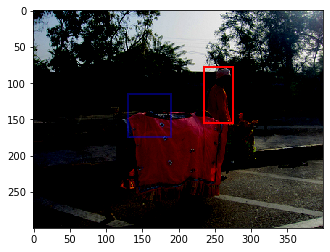

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


anchor coor: 160.0 144.0 59.11852501542981 59.11852501542981
IoU value tensor(0., dtype=torch.float64)


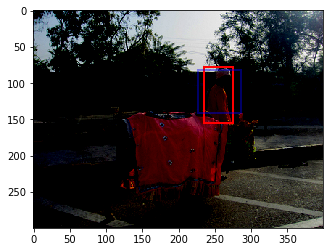

59.11852501542981


In [8]:

### the following function is for the 
def row_gt_matrix(h, w, train_scale_mode):
    anchor_w_h = np.sqrt(train_scale_mode)
    # meshgrid
    xx,yy = np.meshgrid(np.arange(w),np.arange(h))
    xx_feat_to_ori, yy_feat_to_ori = xx*16, yy*16
    # construct the raw_gt information matrix
    anchor_matrix = np.zeros((5,h,w))
    anchor_matrix[1,:,:] = xx_feat_to_ori
    anchor_matrix[2,:,:] = yy_feat_to_ori
    anchor_matrix[3,:,:] = np.ones((h,w))*anchor_w_h
    anchor_matrix[4,:,:] = np.ones((h,w))*anchor_w_h
#     print(xx,yy)
    return anchor_matrix
####
# define the IoU and compute the pairwise IoU between anchor box and gt
def gt_coor_box(box):
#     print("in gt_coor_box function:",box)
    return (box[0]+box[2])/2, (box[1]+box[3])/2, box[2]-box[0], box[3]-box[1]
def IoU(x_a, y_a, w_a, h_a, x_gt, y_gt, w_gt, h_gt):
    # compute the range of the anchor box
    x_a_min = x_a - w_a/2
    x_a_max = x_a + w_a/2
    y_a_min = y_a - h_a/2
    y_a_max = y_a + h_a/2
    # compute the anchor area
    area_a = w_a * h_a
    
    # compute the range of the gt bounding box
    x_gt_min = x_gt - w_gt/2
    x_gt_max = x_gt + w_gt/2
    y_gt_min = y_gt - h_gt/2
    y_gt_max = y_gt + h_gt/2 
    # compute the gt area
    area_gt = w_gt * h_gt
    
    # compute the intersect w & h
    intersect_a_gt_w = max(0,min(x_a_max,x_gt_max)-max(x_a_min,x_gt_min))
    intersect_a_gt_h = max(0,min(y_a_max,y_gt_max)-max(y_a_min,y_gt_min))
    # compute intersect area
    area_intersect = intersect_a_gt_w * intersect_a_gt_h
    # compute union area
    area_union = area_a + area_gt - area_intersect
    IoU = area_intersect / area_union
    return IoU


# IoU adjacent matrix
def adj_IoU(anchor_matrix,gt_bbox):
    # remember to squeeze the batch dimension of the gt_bbox
    # here the bbox is x1y1x2y2 system and anchor box is of xywh system
    gt_len = len(gt_bbox)
    _,h,w = anchor_matrix.shape
    # construct an empty matrix
    adj_IoU_matrix = np.zeros((h*w,gt_len))
    for i in range(h):
        for j in range(w):
#             print(i,j)
            for k,box in enumerate(gt_bbox):
                x_a, y_a, w_a, h_a = anchor_matrix[1:,i,j]
                x_gt, y_gt, w_gt, h_gt = gt_coor_box(box)
                adj_IoU_matrix[i*w + j, k] = IoU(x_a, y_a, w_a, h_a, x_gt, y_gt, w_gt, h_gt)
    return adj_IoU_matrix


def cross_boundary(x_a, y_a, w_a, h_a,H,W):
    # compute the range of the anchor box
    x_a_min = x_a - w_a/2
    x_a_max = x_a + w_a/2
    y_a_min = y_a - h_a/2
    y_a_max = y_a + h_a/2
    
    if x_a_min < 0 or x_a_max > W or y_a_min < 0 or y_a_max > H:
        return True
    return False
def obj_anchor_matrix(img, anchor_matrix, adj_IoU_matrix, bbox, pos_thresh=0.7, neg_thresh = 0.3):
    # remember to squeeze the first dimention of the bbox
    # H, W of img
    _, H, W = img.shape
    # change the first layer into -2 meaning that position is neigther pos/neg
    anchor_matrix[0,:,:] = -1
    # the anchor w&h info
    anchor_w_h = anchor_matrix[3,0,0]
#     print(anchor_w_h)
    # indicate the number of anchors & gt
    num_anchors, num_gt = adj_IoU_matrix.shape
    #------------------------------------------
    # loop through all the anchors first (row of adj_IoU_matrix)
    for i in range (num_anchors):
        ### positive threshold inspection
        if adj_IoU_matrix[i,np.argmax(adj_IoU_matrix[i,:])] >= pos_thresh:
            # find the coresponding x&y
            xidx = i%w
            yidx = i//w
#             print('positive detect')
            # cross-boundary indicator
            x_a, y_a, w_a, h_a = anchor_matrix[1:,yidx,xidx]
            if not cross_boundary(x_a, y_a, w_a, h_a,H,W):
#                 print('positive detect')
                ## retrival the gt information
                # indicate the box index
                box = bbox[np.argmax(adj_IoU_matrix[i,:])]
                # get the information of xywh for gt box
                x_gt, y_gt, w_gt, h_gt = gt_coor_box(box)
                # change the anchor_matrix
                anchor_matrix[0,yidx,xidx] = 1 # positive indicator
                anchor_matrix[1,yidx,xidx] = (x_gt - x_a)/anchor_w_h
                anchor_matrix[2,yidx,xidx] = (y_gt - y_a)/anchor_w_h
                anchor_matrix[3,yidx,xidx] = np.log(w_gt / anchor_w_h)
                anchor_matrix[4,yidx,xidx] = np.log(h_gt / anchor_w_h)
        ### positive threshold inspection
        elif adj_IoU_matrix[i,np.argmax(adj_IoU_matrix[i,:])] < neg_thresh:
            # find the coresponding x&y
            xidx = i%w
            yidx = i//w
            # cross-boundary indicator
            x_a, y_a, w_a, h_a = anchor_matrix[1:,yidx,xidx]
            if not cross_boundary(x_a, y_a, w_a, h_a,H,W):
                ## change the obj entry of the anchor_matrix
                anchor_matrix[0,yidx,xidx] = 0 # negative indicator
    #------------------------------------------
    # loop through all the anchors first (row of adj_IoU_matrix)
    for j in range(num_gt):
        pos_anchor_idx = np.argmax(adj_IoU_matrix[:,j])
        xidx = pos_anchor_idx % w
        yidx = pos_anchor_idx // w
        # cross-boundary indicator
        x_a, y_a, w_a, h_a = anchor_matrix[1:,yidx,xidx]
        if not cross_boundary(x_a, y_a, w_a, h_a,H,W):
            # indicate the box
            box = bbox[j]
            # get the information of xywh for gt box
            x_gt, y_gt, w_gt, h_gt = gt_coor_box(box)
            # change the anchor_matrix
            anchor_matrix[0,yidx,xidx] = 1 # positive indicator
            anchor_matrix[1,yidx,xidx] = (x_gt - x_a)/anchor_w_h
            anchor_matrix[2,yidx,xidx] = (y_gt - y_a)/anchor_w_h
            anchor_matrix[3,yidx,xidx] = np.log(w_gt / anchor_w_h)
            anchor_matrix[4,yidx,xidx] = np.log(h_gt / anchor_w_h)
            
    #------------------------------------------
    # equal sampling 1:1 ratio
    # positive number
    pos_num = np.sum(anchor_matrix[0,:,:]==1)
    # sample the negative index
    neg_num = np.sum(anchor_matrix[0,:,:]==0)
    if neg_num > pos_num:
        # compute the ratio of pos over neg
        # and change the deactivate the negative according to this ratio
        pos_neg_ratio = pos_num / neg_num
        random_deactivate = np.random.binomial(1, pos_neg_ratio, neg_num) - 1
        # change the anchor_matrix
        anchor_matrix_obj = anchor_matrix[0,:,:]
        anchor_matrix_obj[anchor_matrix_obj==0] = anchor_matrix_obj[anchor_matrix_obj==0] + random_deactivate
        anchor_matrix[0,:,:] = anchor_matrix_obj
    return anchor_matrix
# this function output the 5 * h * w gt_matrix, given the img&bbox input
def gt_encoder(img,bbox,h,w,train_scale_mode):
    anchor_matrix = row_gt_matrix(h, w, train_scale_mode)
    adj_IoU_matrix = adj_IoU(anchor_matrix,bbox)
    gt_matrix = obj_anchor_matrix(img, anchor_matrix, adj_IoU_matrix, bbox, pos_thresh=0.7, neg_thresh = 0.3)
    return gt_matrix

    
### TEST DEMO
# from the intermedia step, we could get the w&h for the feature map
h,w = 18,25

img,_,_,bbox = train_dataset[6]
# print(img.shape)
anchor_matrix = row_gt_matrix(h, w, train_scale_mode)
gt_matrix = gt_encoder(img,bbox,h,w,train_scale_mode)
# plot
fig,ax = plt.subplots(1)
plt.imshow(np.array(img).transpose(1,2,0))
for i in range(bbox.shape[0]):
    x1,y1,x2,y2 = bbox[i]
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
    ax.add_patch(rect)

# single anchor test demo
x = 10
y = 9
rect = patches.Rectangle((anchor_matrix[1,y,x]-anchor_matrix[3,y,x]/2,anchor_matrix[2,y,x]-anchor_matrix[4,y,x]/2),anchor_matrix[3,y,x],anchor_matrix[4,y,x],linewidth=1,edgecolor="b",facecolor='none',lw=2,alpha=0.4)    
ax.add_patch(rect)     
        
plt.show()

x_a, y_a, w_a, h_a = anchor_matrix[1:,y,x]
print("anchor coor:",x_a, y_a, w_a, h_a)
box = bbox[0]
x_gt, y_gt, w_gt, h_gt = gt_coor_box(box)
print("IoU value",IoU(x_a, y_a, w_a, h_a, x_gt, y_gt, w_gt, h_gt))



fig,ax = plt.subplots(1)
plt.imshow(np.array(img).transpose(1,2,0))
for i in range(bbox.shape[0]):
    x1,y1,x2,y2 = bbox[i]
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
    ax.add_patch(rect)
for i in range(h):
    for j in range(w):
        if gt_matrix[0,i,j] == 1:
            rect = patches.Rectangle((anchor_matrix[1,i,j]-anchor_matrix[3,i,j]/2,anchor_matrix[2,i,j]-anchor_matrix[4,i,j]/2),anchor_matrix[3,i,j],anchor_matrix[4,i,j],linewidth=1,edgecolor="b",facecolor='none',lw=2,alpha=0.4)    
            ax.add_patch(rect) 
plt.show()
print(np.sqrt(train_scale_mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


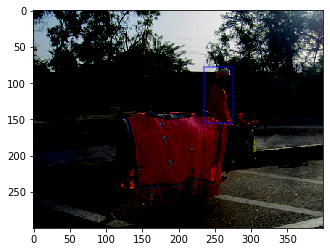

In [9]:
# this function accept the output of the network 
# input: dimension same as gt_matrix 5*h*w (5 contain: 1 objectness, 4 coors)
# plot the box
def decoder(img,output,anchor_matrix):
    # indicate the shape of the output
    _,h,w = output.shape
    # make plot
    fig, ax = plt.subplots(1)
    ax.imshow(np.array(img).transpose(1,2,0))
    # loop through the output_matrix to decode and plot
    for i in range(h):
        for j in range(w):
            # check the objectness
            if output[0,i,j] > 0.1:
                x_a, y_a, w_a, h_a = anchor_matrix[1:,i,j]
                x_shift, y_shift, w_shift, h_shift = output[1:,i,j]
                # the anchor w&h info
                anchor_w_h = anchor_matrix[3,0,0]
                # decode the box
                x_decode = x_shift*anchor_w_h + x_a
                y_decode = y_shift*anchor_w_h + y_a
                w_decode = np.exp(w_shift) * anchor_w_h
                h_decode = np.exp(h_shift) * anchor_w_h
                # add the box
                rect = patches.Rectangle((x_decode-w_decode/2,y_decode-h_decode/2),w_decode,h_decode,linewidth=1,edgecolor="b",facecolor='none',lw=2,alpha=0.4)    
                ax.add_patch(rect)
    plt.show()
decoder(img,gt_matrix,anchor_matrix)

In [10]:
# define the total loss
def totalLoss(X_cls,X_reg,gt_matrix,lambda_loss):
    # indicate the dimension of gt_matrix
    _,h,w = gt_matrix.shape
    
    # inital the cls & reg loss
    cls_loss = 0
    reg_loss = 0
    N_cls = 0
    N_reg = 0
    BCELoss = nn.BCELoss()
    # decompose the gt_matrix into cls & reg part
    gt_cls = gt_matrix[0,:,:]
    gt_reg = gt_matrix[1:,:,:]
#     print(gt_cls.shape)
#     print(X_cls.shape)
    # define the smooth function L1
    smooth_L1 = lambda x: 0.5*x**2 if torch.abs(x)<=1 else torch.abs(x)-0.5
#     vect_L1 = np.vectorize(smooth_L1)
    # loop through the h&w shape to generate the loss
    for i in range(h):
        for j in range(w):
            if gt_cls[i,j] == 1:
                # cls loss part
                N_cls += 1
                cls_loss += BCELoss(X_cls[i,j], gt_cls[i,j])
                # reg loss part
                N_reg += 4
#                 diff_t = X_reg[:,i,j] - gt_reg[:,i,j]
                for k in range(X_reg.shape[0]):
                    diff_t = diff_t = X_reg[k,i,j] - gt_reg[k,i,j]
                    reg_loss += smooth_L1(diff_t)
            elif gt_cls[i,j] == 0:
                N_cls += 1
                cls_loss += BCELoss(X_cls[i,j], gt_cls[i,j])
#     print("N_reg",N_reg)
#     print("N_cls",N_cls)
    absent = True if N_cls == 0 and N_reg == 0 else False
    ret_cls_loss = 0 if N_cls == 0 else cls_loss/N_cls
    ret_reg_loss = 0 if N_reg == 0 else reg_loss/N_reg
    # sum two part of the loss
    total_loss = ret_cls_loss + lambda_loss * ret_reg_loss
    return total_loss, ret_cls_loss, ret_reg_loss, absent


# Train network


In [11]:
# Training 
# initial the network
net = RPN()
net = net.double()
# loss recorder
traning_total_loss = []
traning_cls_loss = []
traning_reg_loss = []
runing_total_loss = 0
runing_cls_loss = 0
runing_reg_loss = 0
record_step = 100
# training parameters
lambda_loss = 1
num_epochs = 30
# define the optimizer
optimizer = optim.Adam(net.parameters(),lr=0.001)

for epoch in range(num_epochs):
    for i,data in enumerate(train_loader,0):
        img, label, mask, bbox = data
#         print(bbox)
#         fig,ax = plt.subplots(1)
#         plt.imshow(np.array(img.squeeze(0)).transpose(1,2,0))
#         for i in range(bbox.squeeze(0).shape[0]):
#             x1,y1,x2,y2 = bbox.squeeze(0)[i]
#             rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
#             ax.add_patch(rect)
#         plt.show()
        # zeros the gradient
        optimizer.zero_grad()
        # construct the gt_matrix 5*h*w
        gt_matrix = gt_encoder(img.squeeze(0),bbox.squeeze(0),h,w,train_scale_mode)
        gt_matrix = torch.tensor(gt_matrix,dtype=torch.double)
        # forward
        X_cls, X_reg = net(img)
#         print(X_cls.size())
#         print(X_reg.size())
        # compute loss
        loss_total, loss_cls, loss_reg, absent = totalLoss(X_cls.squeeze(),X_reg.squeeze(0),gt_matrix,lambda_loss)
        # backwards
        if absent == False:
#             print('backwards')
            loss_total.backward()
            optimizer.step()
        
        runing_total_loss += loss_total
        runing_cls_loss += loss_cls
        runing_reg_loss += loss_reg
        
        if i % record_step == record_step-1:
            print(i+1,' th iter in ',epoch+1,'epoch', runing_total_loss/record_step)
            traning_total_loss.append(runing_total_loss)
            traning_cls_loss.append(runing_cls_loss)
            traning_reg_loss.append(runing_reg_loss)
            runing_total_loss=0
            runing_cls_loss = 0
            runing_reg_loss = 0
            
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'total_loss': traning_total_loss,
                'cls_loss': traning_cls_loss,
                'reg_loss': traning_reg_loss
                }, "./epoch/train_epoch"+str(epoch))

/Users/panlishuo/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


100  th iter in  1 epoch tensor(1.0343, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  1 epoch tensor(0.8673, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  1 epoch tensor(0.8899, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  1 epoch tensor(0.8529, dtype=torch.float64, grad_fn=<DivBackward0>)
500  th iter in  1 epoch tensor(0.8866, dtype=torch.float64, grad_fn=<DivBackward0>)
600  th iter in  1 epoch tensor(0.8091, dtype=torch.float64, grad_fn=<DivBackward0>)
700  th iter in  1 epoch tensor(0.8222, dtype=torch.float64, grad_fn=<DivBackward0>)
800  th iter in  1 epoch tensor(0.7644, dtype=torch.float64, grad_fn=<DivBackward0>)
900  th iter in  1 epoch tensor(0.7320, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  1 epoch tensor(0.7518, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  1 epoch tensor(0.7356, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  1 epoch tensor(0.7983, dtype=torch.float64, g

1900  th iter in  4 epoch tensor(0.4584, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  4 epoch tensor(0.5010, dtype=torch.float64, grad_fn=<DivBackward0>)
2100  th iter in  4 epoch tensor(0.5309, dtype=torch.float64, grad_fn=<DivBackward0>)
2200  th iter in  4 epoch tensor(0.5571, dtype=torch.float64, grad_fn=<DivBackward0>)
2300  th iter in  4 epoch tensor(0.5004, dtype=torch.float64, grad_fn=<DivBackward0>)
2400  th iter in  4 epoch tensor(0.4541, dtype=torch.float64, grad_fn=<DivBackward0>)
2500  th iter in  4 epoch tensor(0.5397, dtype=torch.float64, grad_fn=<DivBackward0>)
2600  th iter in  4 epoch tensor(0.5635, dtype=torch.float64, grad_fn=<DivBackward0>)
100  th iter in  5 epoch tensor(0.5184, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  5 epoch tensor(0.5459, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  5 epoch tensor(0.5130, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  5 epoch tensor(0.4580, dtype=torch.float

1100  th iter in  8 epoch tensor(0.4305, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  8 epoch tensor(0.4045, dtype=torch.float64, grad_fn=<DivBackward0>)
1300  th iter in  8 epoch tensor(0.3431, dtype=torch.float64, grad_fn=<DivBackward0>)
1400  th iter in  8 epoch tensor(0.3905, dtype=torch.float64, grad_fn=<DivBackward0>)
1500  th iter in  8 epoch tensor(0.3354, dtype=torch.float64, grad_fn=<DivBackward0>)
1600  th iter in  8 epoch tensor(0.4136, dtype=torch.float64, grad_fn=<DivBackward0>)
1700  th iter in  8 epoch tensor(0.3834, dtype=torch.float64, grad_fn=<DivBackward0>)
1800  th iter in  8 epoch tensor(0.4164, dtype=torch.float64, grad_fn=<DivBackward0>)
1900  th iter in  8 epoch tensor(0.4855, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  8 epoch tensor(0.4829, dtype=torch.float64, grad_fn=<DivBackward0>)
2100  th iter in  8 epoch tensor(0.3878, dtype=torch.float64, grad_fn=<DivBackward0>)
2200  th iter in  8 epoch tensor(0.3925, dtype=torch.f

200  th iter in  12 epoch tensor(0.2400, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  12 epoch tensor(0.2558, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  12 epoch tensor(0.2943, dtype=torch.float64, grad_fn=<DivBackward0>)
500  th iter in  12 epoch tensor(0.3380, dtype=torch.float64, grad_fn=<DivBackward0>)
600  th iter in  12 epoch tensor(0.3256, dtype=torch.float64, grad_fn=<DivBackward0>)
700  th iter in  12 epoch tensor(0.3098, dtype=torch.float64, grad_fn=<DivBackward0>)
800  th iter in  12 epoch tensor(0.3200, dtype=torch.float64, grad_fn=<DivBackward0>)
900  th iter in  12 epoch tensor(0.3043, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  12 epoch tensor(0.2983, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  12 epoch tensor(0.2846, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  12 epoch tensor(0.2708, dtype=torch.float64, grad_fn=<DivBackward0>)
1300  th iter in  12 epoch tensor(0.2604, dtype=tor

1900  th iter in  15 epoch tensor(0.2924, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  15 epoch tensor(0.1883, dtype=torch.float64, grad_fn=<DivBackward0>)
2100  th iter in  15 epoch tensor(0.2170, dtype=torch.float64, grad_fn=<DivBackward0>)
2200  th iter in  15 epoch tensor(0.2669, dtype=torch.float64, grad_fn=<DivBackward0>)
2300  th iter in  15 epoch tensor(0.2092, dtype=torch.float64, grad_fn=<DivBackward0>)
2400  th iter in  15 epoch tensor(0.3140, dtype=torch.float64, grad_fn=<DivBackward0>)
2500  th iter in  15 epoch tensor(0.1853, dtype=torch.float64, grad_fn=<DivBackward0>)
2600  th iter in  15 epoch tensor(0.2282, dtype=torch.float64, grad_fn=<DivBackward0>)
100  th iter in  16 epoch tensor(0.1865, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  16 epoch tensor(0.2183, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  16 epoch tensor(0.2552, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  16 epoch tensor(0.1771, dtype

1000  th iter in  19 epoch tensor(0.1998, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  19 epoch tensor(0.1347, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  19 epoch tensor(0.1309, dtype=torch.float64, grad_fn=<DivBackward0>)
1300  th iter in  19 epoch tensor(0.1827, dtype=torch.float64, grad_fn=<DivBackward0>)
1400  th iter in  19 epoch tensor(0.2115, dtype=torch.float64, grad_fn=<DivBackward0>)
1500  th iter in  19 epoch tensor(0.1966, dtype=torch.float64, grad_fn=<DivBackward0>)
1600  th iter in  19 epoch tensor(0.1533, dtype=torch.float64, grad_fn=<DivBackward0>)
1700  th iter in  19 epoch tensor(0.1684, dtype=torch.float64, grad_fn=<DivBackward0>)
1800  th iter in  19 epoch tensor(0.1412, dtype=torch.float64, grad_fn=<DivBackward0>)
1900  th iter in  19 epoch tensor(0.2042, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  19 epoch tensor(0.1457, dtype=torch.float64, grad_fn=<DivBackward0>)
2100  th iter in  19 epoch tensor(0.1732, d

100  th iter in  23 epoch tensor(0.1055, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  23 epoch tensor(0.1095, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  23 epoch tensor(0.1360, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  23 epoch tensor(0.1122, dtype=torch.float64, grad_fn=<DivBackward0>)
500  th iter in  23 epoch tensor(0.1600, dtype=torch.float64, grad_fn=<DivBackward0>)
600  th iter in  23 epoch tensor(0.1732, dtype=torch.float64, grad_fn=<DivBackward0>)
700  th iter in  23 epoch tensor(0.1525, dtype=torch.float64, grad_fn=<DivBackward0>)
800  th iter in  23 epoch tensor(0.1000, dtype=torch.float64, grad_fn=<DivBackward0>)
900  th iter in  23 epoch tensor(0.1243, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  23 epoch tensor(0.1704, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  23 epoch tensor(0.1511, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  23 epoch tensor(0.1620, dtype=torc

1800  th iter in  26 epoch tensor(0.1128, dtype=torch.float64, grad_fn=<DivBackward0>)
1900  th iter in  26 epoch tensor(0.1186, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  26 epoch tensor(0.0735, dtype=torch.float64, grad_fn=<DivBackward0>)
2100  th iter in  26 epoch tensor(0.0793, dtype=torch.float64, grad_fn=<DivBackward0>)
2200  th iter in  26 epoch tensor(0.1136, dtype=torch.float64, grad_fn=<DivBackward0>)
2300  th iter in  26 epoch tensor(0.1134, dtype=torch.float64, grad_fn=<DivBackward0>)
2400  th iter in  26 epoch tensor(0.1512, dtype=torch.float64, grad_fn=<DivBackward0>)
2500  th iter in  26 epoch tensor(0.1502, dtype=torch.float64, grad_fn=<DivBackward0>)
2600  th iter in  26 epoch tensor(0.1545, dtype=torch.float64, grad_fn=<DivBackward0>)
100  th iter in  27 epoch tensor(0.1470, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  27 epoch tensor(0.0845, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  27 epoch tensor(0.0823, dtyp

900  th iter in  30 epoch tensor(0.0972, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  30 epoch tensor(0.0576, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  30 epoch tensor(0.1123, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  30 epoch tensor(0.0898, dtype=torch.float64, grad_fn=<DivBackward0>)
1300  th iter in  30 epoch tensor(0.0919, dtype=torch.float64, grad_fn=<DivBackward0>)
1400  th iter in  30 epoch tensor(0.0987, dtype=torch.float64, grad_fn=<DivBackward0>)
1500  th iter in  30 epoch tensor(0.0791, dtype=torch.float64, grad_fn=<DivBackward0>)
1600  th iter in  30 epoch tensor(0.0907, dtype=torch.float64, grad_fn=<DivBackward0>)
1700  th iter in  30 epoch tensor(0.0944, dtype=torch.float64, grad_fn=<DivBackward0>)
1800  th iter in  30 epoch tensor(0.0657, dtype=torch.float64, grad_fn=<DivBackward0>)
1900  th iter in  30 epoch tensor(0.1179, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  30 epoch tensor(0.1109, dt

In [ ]:
# resume training 
net = RPN()
net = net.double()
optimizer = optim.Adam(net.parameters(),lr=0.001)

checkpoint = torch.load("./epoch/train_epoch3")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
traning_total_loss = checkpoint['total_loss']
traning_cls_loss = checkpoint['cls_loss']
traning_reg_loss = checkpoint['reg_loss']

lambda_loss = 1
num_epochs = 30
record_step = 100

runing_total_loss = 0
runing_cls_loss = 0
runing_reg_loss = 0

while epoch < num_epochs:
    for i,data in enumerate(train_loader,0):
        img, label, mask, bbox = data
#         print(bbox)
#         fig,ax = plt.subplots(1)
#         plt.imshow(np.array(img.squeeze(0)).transpose(1,2,0))
#         for i in range(bbox.squeeze(0).shape[0]):
#             x1,y1,x2,y2 = bbox.squeeze(0)[i]
#             rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
#             ax.add_patch(rect)
#         plt.show()
        # zeros the gradient
        optimizer.zero_grad()
        # construct the gt_matrix 5*h*w
        gt_matrix = gt_encoder(img.squeeze(0),bbox.squeeze(0),h,w,train_scale_mode)
        gt_matrix = torch.tensor(gt_matrix,dtype=torch.double)
        # forward
        X_cls, X_reg = net(img)
#         print(X_cls.size())
#         print(X_reg.size())
        # compute loss
        loss_total, loss_cls, loss_reg, absent = totalLoss(X_cls.squeeze(),X_reg.squeeze(0),gt_matrix,lambda_loss)
        # backwards
        if absent == False:
#             print('backwards')
            loss_total.backward()
            optimizer.step()
        
        runing_total_loss += loss_total
        runing_cls_loss += loss_cls
        runing_reg_loss += loss_reg
        
        if i % record_step == record_step-1:
            print(i+1,' th iter in ',epoch+1,'epoch', runing_total_loss/record_step)
            traning_total_loss.append(runing_total_loss)
            traning_cls_loss.append(runing_cls_loss)
            traning_reg_loss.append(runing_reg_loss)
            runing_total_loss = 0
            runing_cls_loss = 0
            runing_reg_loss = 0
            
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'total_loss': traning_total_loss,
                'cls_loss': traning_cls_loss,
                'reg_loss': traning_reg_loss
                }, "./epoch/train_epoch"+str(epoch))

# Test the trained network

In [ ]:
# resume training 
net = RPN()
net = net.double()
optimizer = optim.Adam(net.parameters(),lr=0.001)

checkpoint = torch.load("./epoch/train_epoch29")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
traning_total_loss = checkpoint['total_loss']
traning_cls_loss = checkpoint['cls_loss']
traning_reg_loss = checkpoint['reg_loss']



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


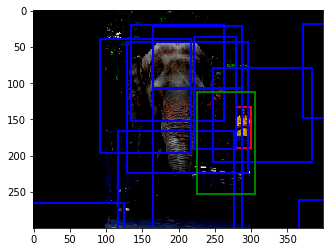

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


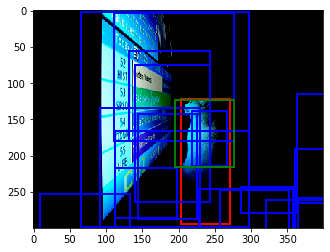

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


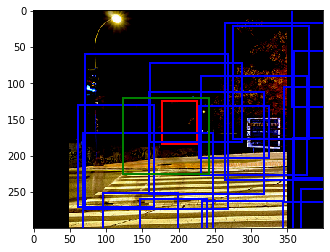

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


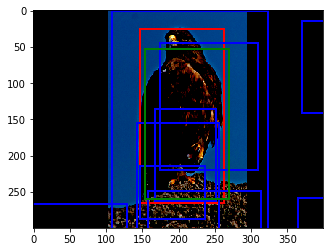

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


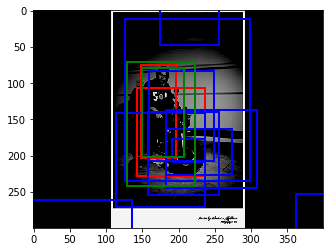

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


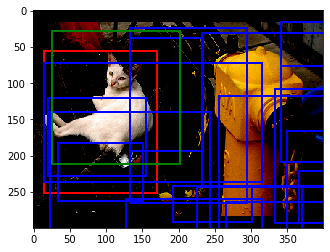

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


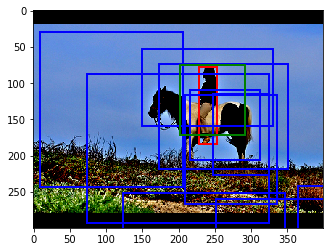

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


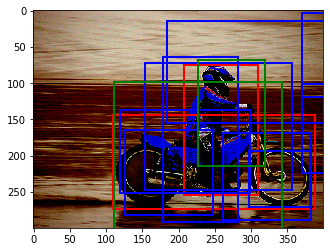

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


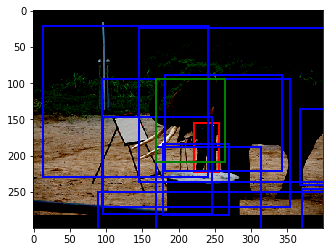

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


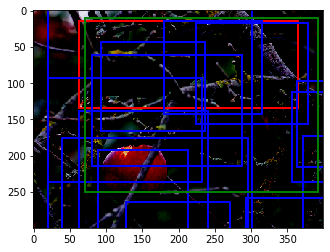

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


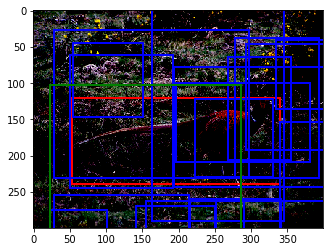

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


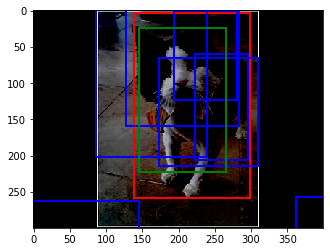

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


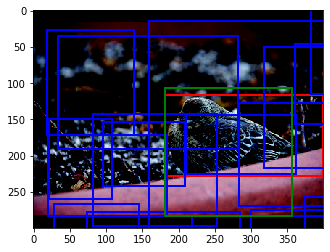

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


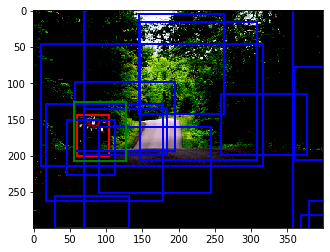

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


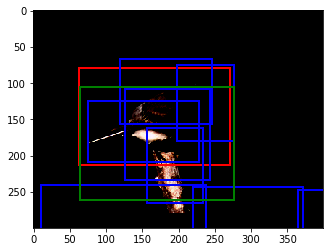

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


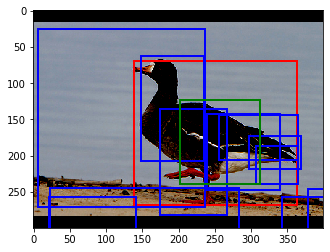

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


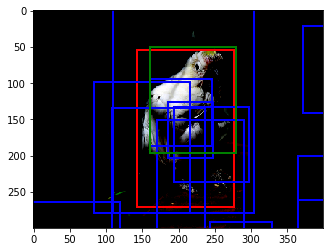

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


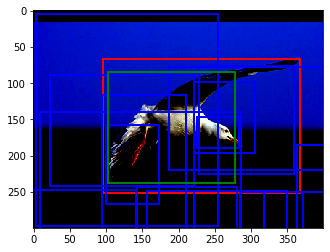

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


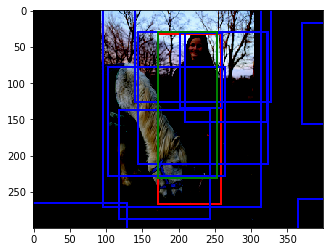

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


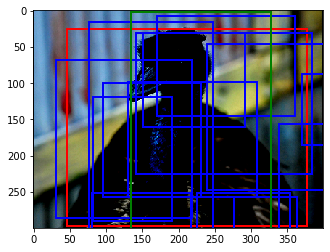

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


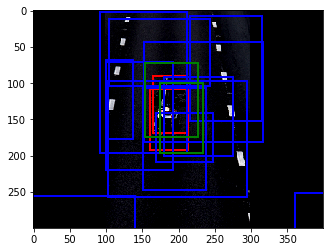

In [82]:
# this function accept the output of the network 
# input: dimension same as gt_matrix 5*h*w (5 contain: 1 objectness, 4 coors)
# plot the box
def decoder(img,bbox,output,anchor_matrix):
    output = output.detach().numpy()
#     output = output.detach().numpy()
    # indicate the shape of the output
    _,h,w = output.shape
    # make plot
    fig, ax = plt.subplots(1)
    ax.imshow(np.array(img).transpose(1,2,0))
    # plot the gt bbox
    for i in range(bbox.shape[0]):
        x1,y1,x2,y2 = bbox[i]
        rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
        ax.add_patch(rect)
    
    # record the IoU
    IoU_max = np.zeros((len(bbox),1))
    IoU_max_idx = np.zeros((len(bbox),2))
    # loop through the output_matrix to decode and plot
    for i in range(h):
        for j in range(w):
#             print(output[0,i,j])
            # check the objectness
            if output[0,i,j] > 0.5:
                x_a, y_a, w_a, h_a = anchor_matrix[1:,i,j]
                x_shift, y_shift, w_shift, h_shift = output[1:,i,j]
                # the anchor w&h info
                anchor_w_h = anchor_matrix[3,0,0]
                # decode the box
                x_decode = x_shift*anchor_w_h + x_a
                y_decode = y_shift*anchor_w_h + y_a
                w_decode = np.exp(w_shift) * anchor_w_h
                h_decode = np.exp(h_shift) * anchor_w_h
                # add the box
                rect = patches.Rectangle((x_decode-w_decode/2,y_decode-h_decode/2),w_decode,h_decode,linewidth=1,edgecolor="b",facecolor='none',lw=2)    
                ax.add_patch(rect)
                # IoU_max update
                for k, box in enumerate(bbox):
                    x_gt, y_gt, w_gt, h_gt = gt_coor_box(box)
                    IoU_cur = np.array(IoU(x_decode, y_decode, w_decode, h_decode,x_gt, y_gt, w_gt, h_gt))
                    if IoU_cur > IoU_max[k]:
#                         print(IoU_max[k])
                        IoU_max[k] = IoU_cur
                        IoU_max_idx[k] = i,j
    for idx in IoU_max_idx:
        
        x_a, y_a, w_a, h_a = anchor_matrix[1:,int(idx[0]),int(idx[1])]
        x_shift, y_shift, w_shift, h_shift = output[1:,int(idx[0]),int(idx[1])]
        # the anchor w&h info
        anchor_w_h = anchor_matrix[3,0,0]
        # decode the box
        x_decode = x_shift*anchor_w_h + x_a
        y_decode = y_shift*anchor_w_h + y_a
        w_decode = np.exp(w_shift) * anchor_w_h
        h_decode = np.exp(h_shift) * anchor_w_h
        # add the box
        rect = patches.Rectangle((x_decode-w_decode/2,y_decode-h_decode/2),w_decode,h_decode,linewidth=1,edgecolor="g",facecolor='none',lw=2)    
        ax.add_patch(rect)
                        
    plt.show()
    
def NMS_RPN(output,anchor_matrix,anchor_h_w,h,w,first_threshold=0,NMS_threshold=0.7):
#     output = output.detach().numpy()
    anchor_matrix = torch.tensor(anchor_matrix,dtype=torch.double)
    ## shift the output to box location
    shift_output = output.clone()
    # x,y shift
#     print(shift_output[1:3,:,:])
    shift_output[1:3,:,:] = shift_output[1:3,:,:] * anchor_h_w
    shift_output[1:3,:,:] = shift_output[1:3,:,:] + anchor_matrix[1:3,:,:]
    # w,h shift
    shift_output[3:,:,:] = torch.exp(shift_output[3:,:,:])
    shift_output[3:,:,:] = shift_output[3:,:,:] * anchor_h_w
    # create copy of output
    output_threshold = output.clone()
    output_NMS = output.clone()
    # sort the grid according to the first channel which is the objectness
    vect_first_channel = shift_output[0,:,:].view(-1,1) # row-based vecterize
    # torch sort
    sorted, indices = torch.sort(vect_first_channel,0,descending=True)
#     print(indices)
    # extract out the index coor
    ind_coor = torch.stack([indices//w,indices%w],1)
#     print('size',sorted.size())
#     print('type',sorted.type())
#     print(sorted)
    sorted = torch.where(sorted > first_threshold,sorted,torch.zeros(sorted.size(),dtype=torch.double))
#     print(sorted)
#     ind_coor.detach().numpy()
    previous_list = []
    for i in range(h*w):
        if sorted[i]==0:
            cur_order_coor_tensor = ind_coor[i].squeeze()
            output_threshold[0,cur_order_coor_tensor[0],cur_order_coor_tensor[1]] = 0
            output_NMS[0,cur_order_coor_tensor[0],cur_order_coor_tensor[1]] = 0
        else:
#             print('current is:', i)
            ## compute the info of current position
            cur_order_coor_tensor = ind_coor[i].squeeze()
#             print('current is:', cur_order_coor_tensor[0],cur_order_coor_tensor[1])
            cur_grid_info = shift_output[:,cur_order_coor_tensor[0],cur_order_coor_tensor[1]].detach().numpy()
#             # find out the class of pred in current grid
#             cur_class = np.argmax(cur_grid_info[5:,])
#             print('cur_class',cur_class)
            # location info of current grid
            cur_x,cur_y,cur_w,cur_h = cur_grid_info[1:,]
#             print('previous is:', i-1)
            
            for element in previous_list:
                # extract out the all previous information
                [pre_x,pre_y,pre_w,pre_h] = element
#                 print('current is:', cur_order_coor_tensor[0],cur_order_coor_tensor[1])
#                 print('previos is:', pre_order_coor_tensor[0],pre_order_coor_tensor[1])
                # compute the IoU between current and previous 
                IoU_cur_pre = IoU(cur_x,cur_y,cur_w,cur_h,
                                  pre_x,pre_y,pre_w,pre_h)
#                 print('position_current',cur_x,cur_y,cur_w,cur_h,'position_previous',pre_x,pre_y,pre_w,pre_h)
#                 print('IoU_cur_pre',IoU_cur_pre)
                # if condition satisfied suppress the current box 
                if IoU_cur_pre >= NMS_threshold:
                    output_NMS[0,cur_order_coor_tensor[0],cur_order_coor_tensor[1]] = 0
                    break
            # if current box survive, record it.
            if output_NMS[0,cur_order_coor_tensor[0],cur_order_coor_tensor[1]] != 0:
                previous_list.append([cur_x,cur_y,cur_w,cur_h])
#             print()
#             print()
#     print(pred_threshold[0,:,:])
    return output_threshold, output_NMS
    
    
# decoder(img,gt_matrix,anchor_matrix)
# test RPN
h,w = 18,25
anchor_matrix = row_gt_matrix(h, w, train_scale_mode)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
for i, test_data in enumerate(test_loader,0):
    img, label, mask, bbox = test_data
    X_cls, X_reg = net(img)
#     print(X_cls.size(),X_reg.size())
    output = torch.cat((X_cls, X_reg), 1)
#     print(output.size())
#     print(output[0,0,:,:])
    output_threshold, output_NMS = NMS_RPN(output.squeeze(0),anchor_matrix,anchor_h_w,h,w,0,0.5)
#     print(output_NMS[0,:,:])
    decoder(img.squeeze(0),bbox.squeeze(0),output_NMS,anchor_matrix)
    if i == 20:
        break
    
    

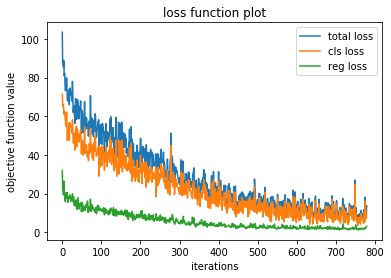

In [85]:
fig, ax = plt.subplots(1)
ax.plot(traning_total_loss, label="total loss")
ax.plot(traning_cls_loss, label="cls loss")
ax.plot(traning_reg_loss, label="reg loss")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function value")
plt.legend()
plt.title("loss function plot")
plt.show()